# Semi-supervised VAE on CIFAR-100 

This notebook contains experiments with semi-supervised VAE on CIFAR-100 data.

reference paper: https://arxiv.org/abs/1406.5298

** Requirements **

This notebook has been implemented using:

- Python 3.7.7
- Numpy 1.18.1
- Pandas 1.0.3
- Scipy 1.4.1
- PyTorch 1.4.0
- torchvision 0.5.0
- Scikit-Learn 0.22.1
- matplotlib 3.1.3
- seaborn 0.10.0

**Install Requirements** (Uncomment if not installed)

In [1]:
# !pip install \
# numpy==1.18.1 \
# pandas==1.0.3 \
# scipy==1.4.1 \
# torch==1.4.0 \
# torchvision==0.5.0 \
# scikit-learn==0.22.2.post1 \
# matplotlib==3.2.1 \
# seaborn==0.10.0

### Imports

In [2]:
# Python lib
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import random
from typing import List, Tuple, Optional
import types
import itertools

# Scientific utilities
import numpy as np
import pandas as pd
from scipy.stats import norm as ndist
from sklearn.metrics import confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.utils import make_grid

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Globals

In [3]:
DATA_DIR = 'data' # relative path to download and store data

BATCH_SIZE = 200

LABELED_DATA_SIZE = 0.30 # in percents

N_CLASSES = 100

** Fixing random seed for reproducibility **

In [4]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

### Preparing Data

Conveniently, PyTorch comes with pre-defined MNIST dataset so we are going to use it directly.

In [5]:
def get_cifar100_ds(train: bool):
    
    seed_everything()

    ds = torchvision.datasets.CIFAR100(DATA_DIR, 
                                      train=train, 
                                      transform=transforms.Compose([
                                        transforms.ToTensor(),
                                      ]),
                                      target_transform=None, 
                                      download=True)

    
    if not train:
        return ds
    
    # making sure that labeled portion of data has equal number of classes (thus making P(Y) uniform prior).
    
    sz = int(LABELED_DATA_SIZE * len(ds) / N_CLASSES)
    cnt = [0] * N_CLASSES
    indices_l = []
    indices_u = []
    
    labels = list(zip(torch.LongTensor(ds.targets).tolist(), range(len(ds))))
    np.random.shuffle(labels) # shuffling data, just in case 
    
    for i in range(len(ds)):
        y, idx = labels[i]
        if cnt[y] != sz:
            cnt[y] += 1
            indices_l.append(idx)
        else:
            indices_u.append(idx)
        
    # making sure we partition the whole data into disjoint labelled/unlabelled subsets correctly.
    assert sorted(indices_l + indices_u) == list(range(len(ds)))
    
    # making sure we can distribute all of the data into equally-sized batches without leftover.
    assert len(indices_l) % BATCH_SIZE == 0
    assert len(indices_u) % BATCH_SIZE == 0
    
    return Subset(ds, indices_l), Subset(ds, indices_u)


In [6]:
def get_cifar100_dls():
    """Returns separate DataLoaders per labelled/unlabelled and validation sets."""
    
    train_ds, train_ds_u = get_cifar100_ds(train=True)
    
    valid_ds = get_cifar100_ds(train=False)
    
    return (torch.utils.data.DataLoader(train_ds, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True, 
                                        pin_memory=False, 
                                        drop_last=True),
            
            torch.utils.data.DataLoader(train_ds_u, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True, 
                                        pin_memory=False, 
                                        drop_last=True),
            
            torch.utils.data.DataLoader(valid_ds, 
                                        batch_size=2 * BATCH_SIZE, 
                                        shuffle=False, 
                                        pin_memory=False, 
                                        drop_last=False))

train_dl, train_dl_u, valid_dl = get_cifar100_dls()

print("Number of labelled, unlabelled and valid samples: ", len(train_dl.dataset), 
                                                            len(train_dl_u.dataset), 
                                                            len(valid_dl.dataset)) 
      
print("Number of labelled, unlabelled and valid batches: ", len(train_dl), 
                                                            len(train_dl_u), 
                                                            len(valid_dl))

Files already downloaded and verified
Files already downloaded and verified
Number of labelled, unlabelled and valid samples:  15000 35000 10000
Number of labelled, unlabelled and valid batches:  75 175 25


**Showing a few samples from the dataset**


Batch Statistics:
 shape: torch.Size([200, 3, 32, 32]), mean: 0.48430541157722473, std: 0.27730271220207214, min: 0.0, max: 1.0
Batch Statistics:
 shape: torch.Size([200, 3, 32, 32]), mean: 0.47192010283470154, std: 0.2687099277973175, min: 0.0, max: 1.0
Batch Statistics:
 shape: torch.Size([200, 3, 32, 32]), mean: 0.45979300141334534, std: 0.2608751952648163, min: 0.0, max: 1.0


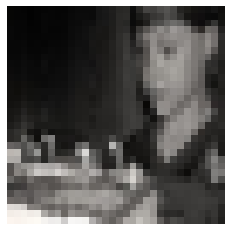

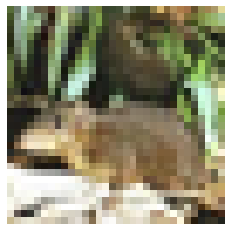

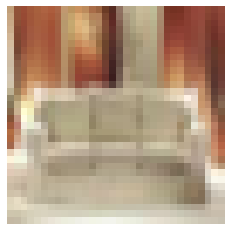

In [7]:
for i, (x, y) in enumerate(train_dl):
    print(f"Batch Statistics:\n shape: {x.shape}, mean: {x.mean()}, std: {x.std()}, min: {x.min()}, max: {x.max()}")
    
    grid = make_grid([x[0]], pad_value=1, padding=1, nrow=1)
    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
        
    if i > 1: break

### Defining Model Simple MLP

In [8]:
def init_weights(m: nn.Module):

    for m in m.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, a=0.02, nonlinearity='leaky_relu')
            nn.init.constant_(m.bias, 0)

def one_hot(y, n_classes: int) -> torch.FloatTensor:
    
    assert y.ndim <= 2
    
    bs = y.shape[0]
    
    y_onehot = torch.zeros(bs, n_classes, device=y.device).long()
    y_onehot.scatter_(1, y.view(bs, -1).long(), 1)

    return y_onehot.float()

In [9]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [10]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, n_classes, hidden_dim, out_dim):
        super(Encoder, self).__init__()
        
        # input (B, C=3, H=32, W=32), output (B, C=64, H=16, W=16)
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        
        # input (B, C=64, H=16, W=16), output (B, C=128, H=8, W=8)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        
        # input (B, C=128, H=8, W=8), output (B, C=128, H=8, W=8)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        
        # input (B, C=128, H=8, W=8), output (B, C=128, H=8, W=8)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        # input (B, C=128, H=8, W=8), output (B, C=32, H=10, W=10)
        self._conv_4 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens//4,
                                 kernel_size=1,
                                 stride=1, padding=1)
        
        # feat_shapes (32*10*10=3200 and 32*10*10+100=3300)
        self.feat_shape = (num_hiddens//4)*10*10
        self.feat_and_target_shape = self.feat_shape + n_classes
        
        # input (B, (C*H*W + n_classes)=32*10*10+100), output (B, out_dim)
        self.fc_layer = nn.Sequential(
            nn.Linear(self.feat_and_target_shape, out_dim),
        )
        
        init_weights(self)

    def forward(self, x, y):
        enc_x = F.relu(self._conv_1(x))
        enc_x = F.relu(self._conv_2(enc_x))
        enc_x = self._conv_3(enc_x)
        enc_x = self._residual_stack(enc_x)
        enc_x = self._conv_4(enc_x)
        
        enc_xy = torch.cat([enc_x.view(-1, self.feat_shape), y], dim=1)
        
        return self.fc_layer(enc_xy)
    

In [11]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, n_classes, hidden_dim, out_dim):
        super(Decoder, self).__init__()
        
        # feat_shapes (32*10*10=3200 and 32*10*10+100=3300)
        self.feat_shape = num_hiddens//4*10*10
        self.feat_and_target_shape = self.feat_shape + n_classes
        
        # input (B, out_dim + n_classes) output (B, C*H*W=32*10*10)
        self.fc_back_layer = nn.Sequential(
            nn.Linear(out_dim + n_classes, self.feat_shape),
        )
        
        # input (B, C=32, H=10, W=10) output (B, C=128, H=8, W=8)
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=in_channels,
                                             out_channels=num_hiddens,
                                             kernel_size=1, 
                                             stride=1, padding=1)
        
        # input (B, C=128, H=8, W=8) output (B, C=128, H=8, W=8)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        # input (B, C=128, H=8, W=8) output (B, C=128, H=8, W=8)
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens,
                                                kernel_size=3, 
                                                stride=1, padding=1)
        
       # input (B, C=128, H=8, W=8) output (B, C=64, H=16, W=16)
        self._conv_trans_3 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        
        
        # input (B, C=64, H=16, W=16) output (B, C=3, H=32, W=32)
        self._conv_trans_4 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        

    def forward(self, z, y):
        z_y = self.fc_back_layer(torch.cat([z, y], dim=1))
        enc_x = z_y.view(
            -1, 
            num_hiddens//4,
            10,
            10
        )
        dec_x = self._conv_trans_1(enc_x)
        dec_x = self._residual_stack(dec_x)
        dec_x = F.relu(self._conv_trans_2(dec_x))
        dec_x = F.relu(self._conv_trans_3(dec_x))
        return self._conv_trans_4(dec_x)

In [12]:
class Classifier(nn.Module):
    def __init__(self, image_size: int, n_classes:int, channel_num:int, kernel_num:int, hidden_dim:int):
        super().__init__()
        
        self.feature_size = image_size // 8
        self.feature_volume = kernel_num * (self.feature_size ** 2)
        
        self.conv_layers = nn.Sequential(
            self._conv(channel_num, kernel_num // 4),
            self._conv(kernel_num // 4, kernel_num // 2),
            self._conv(kernel_num // 2, kernel_num),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(self.feature_volume, hidden_dim),
            nn.LeakyReLU(0.02),
            nn.Linear(hidden_dim, n_classes)
        )
        
        init_weights(self)
        
    def forward(self, x): 
        enc_x = self.conv_layers(x)
        features = enc_x.view(-1, self.feature_volume)
        return self.fc_layer(features)
    
    def _conv(self, channel_size, kernel_num):
        return nn.Sequential(
            nn.Conv2d(
                channel_size, kernel_num,
                kernel_size=4, stride=2, padding=1,
            ),
            nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
        )

In [13]:
class SSVAE(nn.Module):    
    def __init__(self, image_size: int, # 32 in case of CIFAR-100 
                 n_classes:int, # 100 num of classes in CIFAR-100 
                 channel_num:int, # 3 num of channels of image (3, 32, 32)
                 kernel_num:int, # 128 number of kernels
                 clf_hidden_dim: int, # classifier hidden dim 
                 enc_dec_hidden_dim: int, # encoder and decoder hidden dim
                 z_dim: int, # z latent variables dim
                 out_dim: int, # out dimension of encoder and input dimension of decoder
                 num_hiddens:int, # number of channels in hidden dimension
                 num_residual_layers:int, # 2 number of residual layers in encoder and decoder
                 num_residual_hiddens:int, # 32 number of hidden in residual layer
                ):
        
        super().__init__()
        self.n_classes = n_classes
        self.image_shape = (channel_num, image_size, image_size)
        
        # q(z|x,y) = Normal(z | mu, diag(sigma^2) = MLP(x, y))
        self.enc =  Encoder(
            channel_num, num_hiddens, num_residual_layers, num_residual_hiddens, 
            n_classes, enc_dec_hidden_dim, out_dim
        )
        
        # p(x|z,y) = Bernoulli(x | p = MLP(z, y))
        self.dec = Decoder(
            num_hiddens//4, num_hiddens, num_residual_layers, num_residual_hiddens, 
            n_classes, enc_dec_hidden_dim, out_dim
        )
        
        # q(y|x) = Categorical(y | p = MLP(x))
        self.cls = Classifier(
            image_size=image_size, n_classes=n_classes, channel_num=channel_num,
            kernel_num=kernel_num, hidden_dim=clf_hidden_dim
        ) 
        
        # q
        self.q_mean     = nn.Linear(out_dim, z_dim)
        self.q_logvar = nn.Linear(out_dim, z_dim)
        
        # projection
        self.project = nn.Linear(z_dim, out_dim)
        
        init_weights(self)
        
    def encode(self, x, y):
        enc = self.enc(x, one_hot(y, self.n_classes))
        
        return self.q_mean(enc), self.q_logvar(enc)
    
    def cls_logits(self, x):
        
        return self.cls(x)
        
    def sample_z(self, mu, logvar):        
        eps = torch.empty_like(mu).normal_(0, 1)
        
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z, y):
        
        return self.dec(self.project(z), one_hot(y, self.n_classes)).view(-1, *self.image_shape)
        
    def forward(self, x, y=None):
        
        if y is None:
            y = torch.argmax(self.cls_logits(x), dim=1)
        
        mu, logvar = self.encode(x, y)
        
        z = self.sample_z(mu, logvar)
        
        return self.decode(z, y)

## Assemble Network Parts

In [14]:
# encoder and decoder
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

# entire model
clf_hidden_dim = 512
enc_dec_hidden_dim = 1024
out_dim = 512
n_classes=100
channel_num=3

# for classifier
image_size=32
kernel_num=128
z_dim = 256

In [15]:
enc = Encoder(
    channel_num, num_hiddens,num_residual_layers, num_residual_hiddens,
    n_classes, enc_dec_hidden_dim, out_dim
)

dec = Decoder(
    num_hiddens//4, num_hiddens,num_residual_layers, num_residual_hiddens,
    n_classes, enc_dec_hidden_dim, out_dim
)

enc_x = enc(x, one_hot(y, n_classes))

assert tuple(enc_x.shape) == (BATCH_SIZE, out_dim)

dec_x = dec(enc_x, one_hot(y, n_classes))

assert tuple(dec_x.shape) == tuple(x.shape)

vae = SSVAE(
    image_size, n_classes, channel_num, kernel_num, 
    clf_hidden_dim, enc_dec_hidden_dim, z_dim, out_dim,
    num_hiddens, num_residual_layers, num_residual_hiddens
)

dec_x = vae(x,y)

assert tuple(dec_x.shape) == tuple(x.shape) 

### Defining Loss 

In [16]:
def kl_loss(mu, logvar):
    """KL_Divergence[N(mu, logvar.exp()), N(0, 1)]"""
    
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

def loss_xy(x, x_recon, mu, logvar):
    """Returns negative ELBO(x, y) with y - class index. Eq. 6 in the paper."""
    
    bce = torch.nn.functional.binary_cross_entropy_with_logits(x_recon, x, reduction='none').sum(dim=(1, 2, 3))

    logPy = np.log(1.0 / N_CLASSES) # prior is uniform due to ballanced classes.
    
    kl = kl_loss(mu, logvar)
    
    return bce - logPy + kl

In [17]:
def loss_x_binning(model: nn.Module, x, y_probs):
    "Loss for unlabelled batch with binning to reduce computation time."
    
    s = torch.zeros(x.shape[0], device=x.device).cuda()  

    y_probs = torch.softmax(model.cls_logits(x.cuda()), dim=-1)

    y_entropy = torch.distributions.Categorical(y_probs).entropy()

    y_bins = np.digitize(y_probs.cpu().detach().numpy(), [i/10 for i in range(1, 10)])

    found_bins = set(y_bins.reshape(-1))   

    for bin_id in found_bins:
                
        y_one_hot = torch.FloatTensor((y_bins == bin_id).astype(int)).cuda()

        xy_enc = model.enc(x.cuda(), y_one_hot)

        mu = model.q_mean(xy_enc)

        logvar = model.q_logvar(xy_enc)

        z = model.sample_z(mu, logvar)

        x_recon = model.dec(model.project(z), y_one_hot).view(-1, *model.image_shape)

        y_probs_bins_onehot = torch.FloatTensor((y_bins == bin_id).astype(int)).cuda()

        y_probs_bins = y_probs * y_probs_bins_onehot

        y_loss_mean = (y_probs_bins.sum(dim=1)/(y_probs_bins_onehot + 1e-10).sum(dim=1))

        rec_x_loss = loss_xy(x.cuda(), x_recon, mu, logvar)

        s += y_loss_mean * rec_x_loss
                    
    return (s + y_entropy).mean()

In [18]:
def loss_x(model: nn.Module, x, y_probs):
    "Loss for unlabelled batch. Eq. 7 in the paper."
    
    s = torch.zeros(x.shape[0], device=x.device)
    
    y_entropy = torch.distributions.Categorical(y_probs).entropy()
    
    for i in range(y_probs.shape[-1]):
        
        y = torch.empty(x.shape[0], device=x.device).fill_(i)
        
        mu, logvar = model.encode(x, y)
        
        x_recon = model.decode(model.sample_z(mu, logvar), y)
        
        s += y_probs[:, i] * loss_xy(x, x_recon, mu, logvar)
                
    return (s + y_entropy).mean()

### Training Loop

This section contains model training loop as well as some helper/visualization functions. 

In [19]:
def try_get_batch(it):
    
    x, y = None, None
    try:
        x, y = next(it)
    except StopIteration:
        pass
    
    return x, y

def get_next_batch(train_dl, train_dl_u):
    """Returns a next batch, either labelled or unlabelled, making equal gaps between alternations."""

    it_l, it_u = iter(train_dl), iter(train_dl_u)
    
    for i in range(1, 1 << 30):
        
        unlabelled = i % (len(train_dl_u) // len(train_dl)) != 0
#         unlabelled = False # for not using unlabeled dataset (testing purposes)
                
        if unlabelled:
            x, y = try_get_batch(it_u)
            has_label = False
            
        if (not unlabelled) or (x is None):
            x, y = try_get_batch(it_l)
            has_label = True
        
        if x is None:
            return None, None, has_label
        
        yield x, y, has_label

In [20]:
class MetricLogger:
    """Helper class for logging metrics"""
    
    def __init__(self, name, init_val = 0):
        
        self.name = name
        self.init_val = init_val
        
        self.counter = 0
        
        self.logs = []
        
    def log(self, val):
        
        self.logs.append(val)
        
        self.counter += 1
        
    def reset(self):
        self.counter = 0
        
    @property
    def val(self):
        
        data = self.logs[len(self.logs) - self.counter:]
        
        mean, std = np.mean(data), np.std(data) 
        
        return f"Avg %s: %.5f (±%.3f)" % (self.name, mean, std)
    
    def plot(self):
        plt.title(self.name)
        plt.plot(self.logs)

In [21]:
def get_preds(valid_dl: DataLoader, model: nn.Module):
    
    model.eval()
    model.cuda()
    
    y_preds, y_trues = [], []
    with torch.no_grad():
        for x, y in valid_dl:
            
            y_pred = torch.argmax(model.cls_logits(x.cuda()), dim=1).long().tolist()
            
            y_preds.extend(y_pred)
            y_trues.extend(y.tolist())
            
    model.train()
    
    return y_trues, y_preds

In [22]:
def show_summary(valid_dl: DataLoader, model: nn.Module, acc_logger: Optional[MetricLogger] = None):
    """This is a helper function for visualizing model output quality during the training process."""
    
    N_SAMPLES = 15
    
    model.eval()
    
    actuals, preds = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl.dataset):
            
            actuals.append(x)
            recon_x = model(x.unsqueeze(0).cuda(), torch.Tensor([[y]]).cuda()).sigmoid().cpu()
            
            preds.append(recon_x.view(*x.shape))
            
            if i + 1 == N_SAMPLES:
                break
                            
    grid = make_grid([*actuals, *preds], pad_value=1, padding=1, nrow=N_SAMPLES)
    
    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show() 
    
    y_trues, y_preds = get_preds(valid_dl, model)
    
    cm = confusion_matrix(y_trues, y_preds)
    
    if acc_logger:
        acc_logger.log(np.trace(cm) / float(np.sum(cm)))
        
    model.train()

In [23]:
def train_vae(train_dl: DataLoader, # labelled batch dataloader
              train_dl_u: DataLoader, # unlabelled batch dataloader
              valid_dl: DataLoader, # validation set dataloader
              model: nn.Module,
              n_epochs: int,
              loss_logger: MetricLogger,
              cls_loss_logger: MetricLogger,
              acc_logger: MetricLogger,
              semi_sup_epochs: int, # number of initial epochs after which training becomes fully unsupervised
              learning_rate=1e-5,
              weight_decay=1e-7,
              summary_interval=40,
              log_interval=20,
              cls_loss_weight_coeff=0.1
              ): 
    
    LOG_INTERVAL = log_interval
    SUMMARY_INTERVAL = summary_interval
    
    CLS_LOSS_WEIGHT = cls_loss_weight_coeff * len(train_dl.dataset) # as in paper
    
    model = model.cuda()
    
    cls_crit = nn.CrossEntropyLoss()
    
    model.train()
    
    # I use default lr, weight decay, and lr annealing schedule. Fintuning can improve results...
    
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.5)
    
    for epoch in range(n_epochs):
        
        uns_batches_cnt = 0

        for i, (x, y, has_label) in enumerate(get_next_batch(train_dl, train_dl_u)):
            
            if x is None: break
        
            optim.zero_grad()
            
            x = x.cuda()
            y = y.cuda()
            
            y_logits = model.cls_logits(x)
            
            cls_loss = cls_crit(y_logits, y)

            if has_label:
                
                # after semi_sup_epochs training becomes fully unsupervised. 
                # This allows us to see that after semi-supervised warmup, classifier is able to continue learning without labels, taking knowledge indirectly from generative process.
                # I tested this phenomenon with semi_sup_epochs=1 and z_dim=50 below...
                if epoch >= semi_sup_epochs: 
                    continue
                                    
                mu, logvar = model.encode(x, y)
                
                z = model.sample_z(mu, logvar)

                x_recon = model.decode(z, y)

                loss = loss_xy(x, x_recon, mu, logvar).mean() + CLS_LOSS_WEIGHT * cls_loss
                                
            else:
                
                loss = loss_x_binning(model, x, torch.softmax(y_logits, dim=-1))
#                 loss = loss_x(model, x, torch.softmax(y_logits, dim=-1))
                
                uns_batches_cnt += 1

                
            loss_logger.log(loss.item())
            cls_loss_logger.log(cls_loss.item())
            
            loss.backward()
            
            optim.step()
            
            if (epoch < semi_sup_epochs and (i + 1) % LOG_INTERVAL == 0) or \
                epoch >= semi_sup_epochs and uns_batches_cnt % LOG_INTERVAL ==0:
                
                print('epoch %d | iter %d | %s | %s' % (epoch + 1, i + 1, loss_logger.val, cls_loss_logger.val))
                
                loss_logger.reset()
                cls_loss_logger.reset()
            
            if (epoch < semi_sup_epochs and (i + 1) % SUMMARY_INTERVAL == 0) or \
                epoch >= semi_sup_epochs and uns_batches_cnt % SUMMARY_INTERVAL ==0:
                show_summary(valid_dl, model, acc_logger)
                pass
            
        #lr_scheduler.step()
        

In [24]:
seed_everything()
vae = SSVAE(
    image_size, n_classes, channel_num, kernel_num, 
    clf_hidden_dim, enc_dec_hidden_dim, z_dim, out_dim,
    num_hiddens, num_residual_layers, num_residual_hiddens
)

loss_logger = MetricLogger("Loss")
cls_loss_logger = MetricLogger("Cls Loss")
acc_logger = MetricLogger('Accuracy')

epoch 1 | iter 20 | Avg Loss: 4621.62760 (±4580.850) | Avg Cls Loss: 4.71688 (±0.211)
epoch 1 | iter 40 | Avg Loss: 4381.42808 (±4326.149) | Avg Cls Loss: 4.36111 (±0.078)


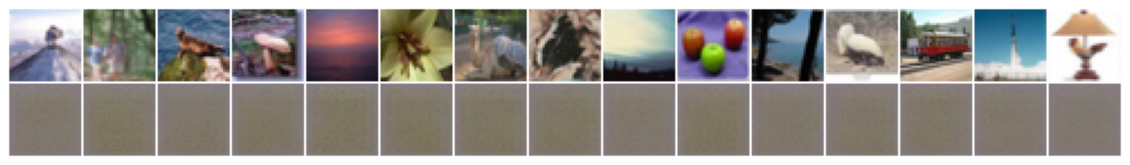

epoch 1 | iter 60 | Avg Loss: 4217.97878 (±4148.808) | Avg Cls Loss: 4.19705 (±0.078)
epoch 1 | iter 80 | Avg Loss: 4142.02467 (±4039.212) | Avg Cls Loss: 4.09821 (±0.056)


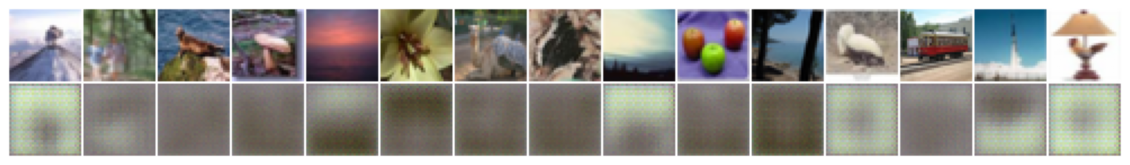

epoch 1 | iter 100 | Avg Loss: 4039.73084 (±3927.981) | Avg Cls Loss: 3.99343 (±0.086)
epoch 1 | iter 120 | Avg Loss: 3971.99988 (±3851.574) | Avg Cls Loss: 3.92932 (±0.046)


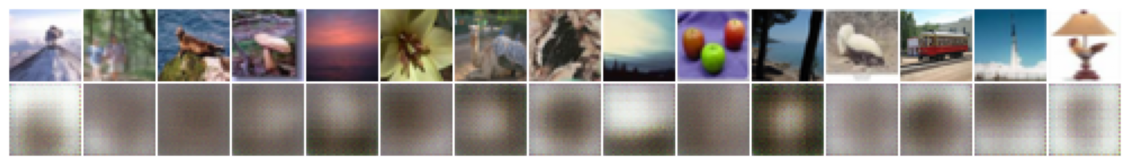

epoch 1 | iter 140 | Avg Loss: 3925.78465 (±3797.730) | Avg Cls Loss: 3.87377 (±0.056)
epoch 2 | iter 20 | Avg Loss: 3642.81105 (±3610.628) | Avg Cls Loss: 3.72272 (±0.140)
epoch 2 | iter 40 | Avg Loss: 3685.74557 (±3511.345) | Avg Cls Loss: 3.63345 (±0.118)


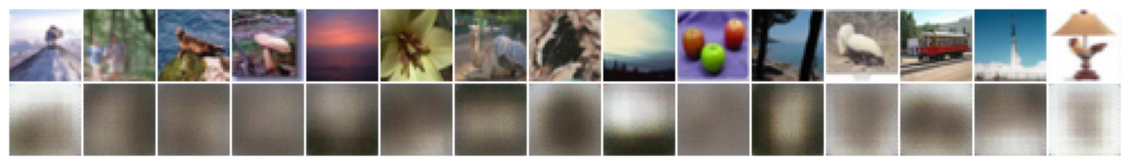

epoch 2 | iter 60 | Avg Loss: 3685.53268 (±3487.910) | Avg Cls Loss: 3.59964 (±0.138)
epoch 2 | iter 80 | Avg Loss: 3673.21734 (±3460.801) | Avg Cls Loss: 3.56090 (±0.124)


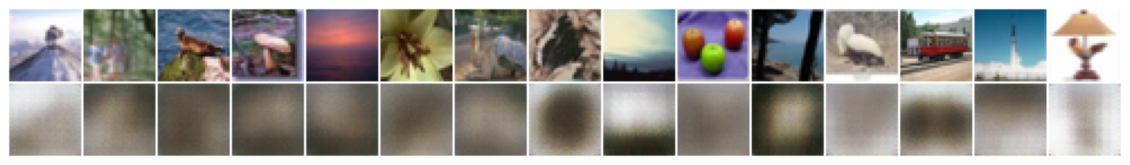

epoch 2 | iter 100 | Avg Loss: 3659.57493 (±3446.846) | Avg Cls Loss: 3.56891 (±0.118)
epoch 2 | iter 120 | Avg Loss: 3632.21229 (±3404.636) | Avg Cls Loss: 3.54391 (±0.141)


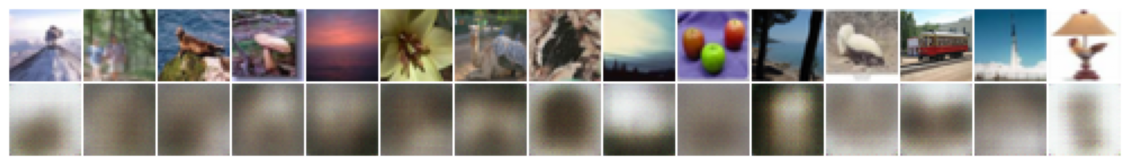

epoch 2 | iter 140 | Avg Loss: 3615.02642 (±3380.214) | Avg Cls Loss: 3.51255 (±0.137)
epoch 3 | iter 20 | Avg Loss: 3337.58154 (±3190.066) | Avg Cls Loss: 3.37039 (±0.253)
epoch 3 | iter 40 | Avg Loss: 3357.60679 (±3084.797) | Avg Cls Loss: 3.31887 (±0.303)


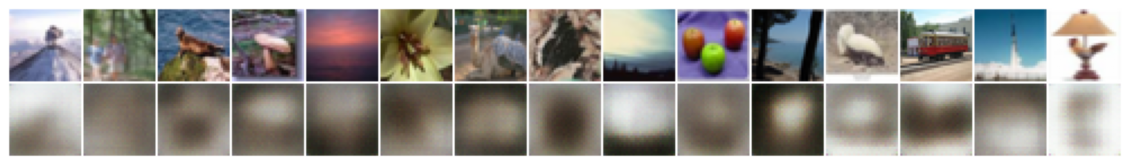

epoch 3 | iter 60 | Avg Loss: 3375.79893 (±3091.102) | Avg Cls Loss: 3.27695 (±0.240)
epoch 3 | iter 80 | Avg Loss: 3387.53642 (±3101.114) | Avg Cls Loss: 3.27854 (±0.218)


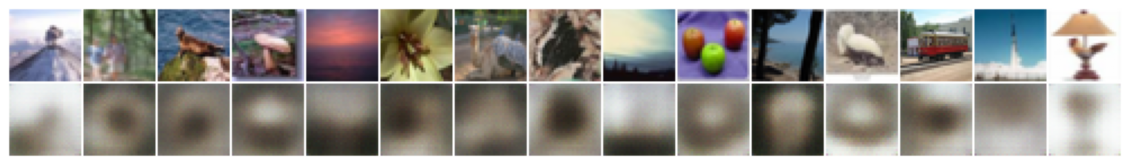

epoch 3 | iter 100 | Avg Loss: 3414.48606 (±3134.958) | Avg Cls Loss: 3.30830 (±0.214)
epoch 3 | iter 120 | Avg Loss: 3393.14063 (±3090.040) | Avg Cls Loss: 3.27313 (±0.219)


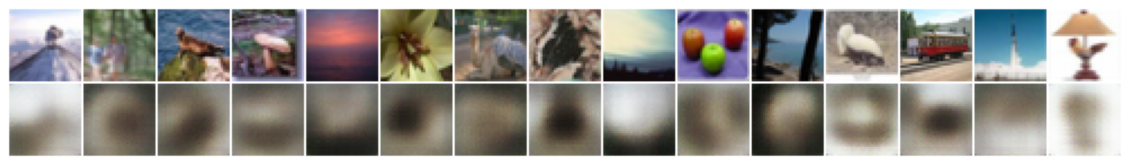

epoch 3 | iter 140 | Avg Loss: 3392.08723 (±3072.829) | Avg Cls Loss: 3.27164 (±0.218)
epoch 4 | iter 20 | Avg Loss: 3081.42581 (±2868.494) | Avg Cls Loss: 3.12259 (±0.364)
epoch 4 | iter 40 | Avg Loss: 3078.54709 (±2743.977) | Avg Cls Loss: 3.04806 (±0.422)


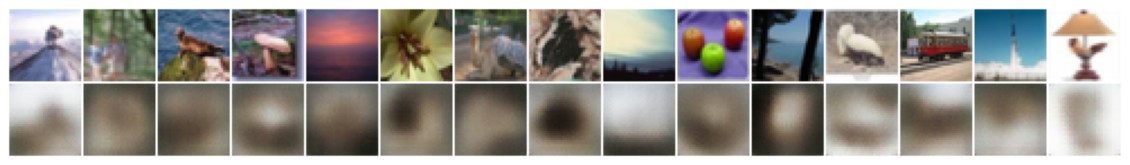

epoch 4 | iter 60 | Avg Loss: 3104.25298 (±2747.363) | Avg Cls Loss: 3.02512 (±0.375)
epoch 4 | iter 80 | Avg Loss: 3079.15670 (±2713.310) | Avg Cls Loss: 3.03795 (±0.426)


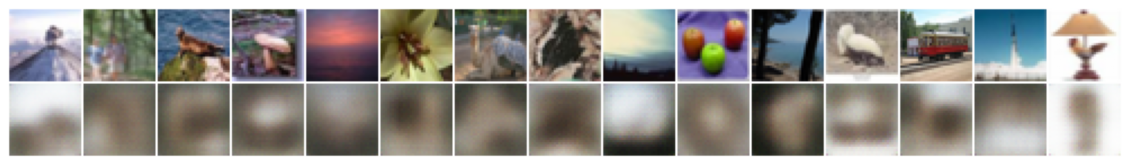

In [ ]:
train_vae(
    train_dl, train_dl_u, valid_dl, vae, 
    30, loss_logger, cls_loss_logger, acc_logger, 
    semi_sup_epochs=100000, learning_rate=2e-4, weight_decay=1e-4
)

** Plotting Metrics **

In [ ]:
acc_logger.plot()

In [ ]:
loss_logger.plot()

In [ ]:
cls_loss_logger.plot()

#### store modela after 10 epochs

In [ ]:
MODEL_PATH = 'model/30_epochs_vae.pth'

In [ ]:
torch.save(vae.state_dict(), MODEL_PATH)

### Generating Images

In [243]:
Classes = list(range(10))

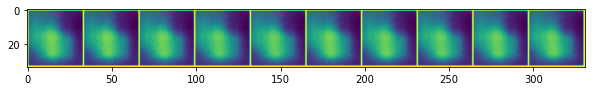

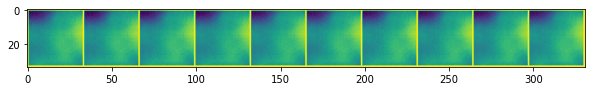

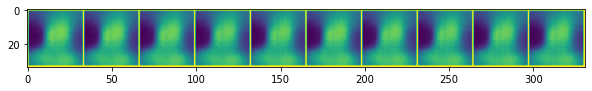

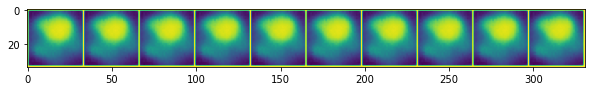

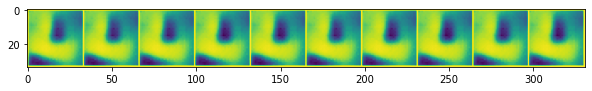

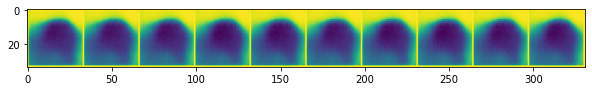

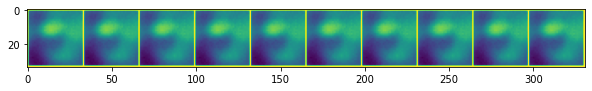

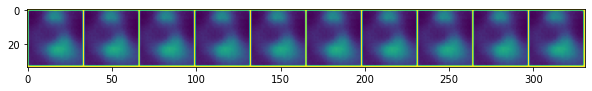

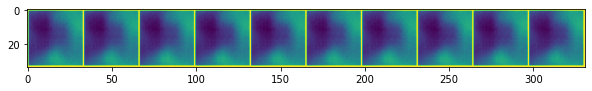

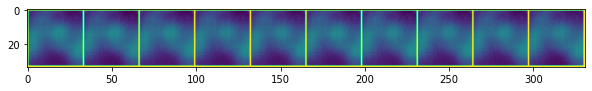

In [244]:
# generate 10 times
for i in range(10):
    z_ = torch.empty(z_dim).normal_(0, 1).repeat(len(Classes), 1)

    y = torch.Tensor([i % len(Classes) for i in range(len(Classes))])

    images = vae.decode(z_.cuda(), y.cuda()).sigmoid().detach().cpu()

    grid = make_grid(images, pad_value=1, padding=1, nrow=10)[0].detach().numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(grid);

### Unsupervised Training

In this section I show that after the first epoch (warmup) we can switch to fully-unsupervised training and classifier will still improve its score by getting indirect supervision from generative process. In other words, learning classifier and generative model jointly isn't useless.

In [ ]:
seed_everything()
vae = SSVAE(
    image_size, n_classes, channel_num, kernel_num, 
    clf_hidden_dim, enc_dec_hidden_dim, z_dim, out_dim,
    num_hiddens, num_residual_layers, num_residual_hiddens
)

In [ ]:
# I also log gradient norm at classifier's last layer to compare signal strength in labelled VS unlabelled batch scenarios.

cls_grad_norm = MetricLogger('cls_grad_norm')

def record_grad_norm(self, grad_input, grad_output):
    cls_grad_norm.log(grad_input[0].norm())

vae.cls.fc_layer[-1].register_backward_hook(record_grad_norm)

dec_grad_norm = MetricLogger('dec_grad_norm')

def record_grad_norm(self, grad_input, grad_output):
    dec_grad_norm.log(grad_input[0].norm())

vae.dec.fc_back_layer[-1].register_backward_hook(record_grad_norm)

In [ ]:
loss_logger = MetricLogger("Loss")
cls_loss_logger = MetricLogger("Cls Loss")
acc_logger = MetricLogger('Accuracy')

In [ ]:
vae.load_state_dict(torch.load(MODEL_PATH))

In [ ]:
train_vae(
    train_dl, train_dl_u, valid_dl, vae, 
    200, loss_logger, cls_loss_logger, acc_logger, 
    semi_sup_epochs=0, learning_rate=1e-4, weight_decay=1e-5
)

In [ ]:
acc_logger.plot()

In [ ]:
# we can see that classifier learns fast during semi-supervised setting (high gradient signal) and much slower afterrwards (signal is small, yet nonzero).

cls_grad_norm.plot()

In [ ]:
dec_grad_norm.plot()